In [85]:
import xgboost as xgb
import pandas as pd
import sqlalchemy
import yahooquery as yq
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np
import requests
import matplotlib.pyplot as plt
import datetime as dt

In [135]:
engine = sqlalchemy.create_engine('sqlite:///' + "Financial.db", execution_options={"sqlite_raw_colnames": True})
df_financial = pd.read_sql_table('FinancialDataJoined', engine)

engine = sqlalchemy.create_engine('sqlite:///' + "SEC_Filings.db", execution_options={"sqlite_raw_colnames": True})
df_sentiments = pd.read_sql_table('Aggregated_Sentiment_Scores', engine)
df_SIC = pd.read_sql_table("10K_Data", engine)
df_SIC = df_SIC[['SIC', 'CIK']]

agri = ['0100', '0200', '0900']
fin = ['6172', '6199', '6200', '6211', '6221', '6282']
air = ['4513', '4522', '4581']
bank = ['6022', '6029', '6035', '6036', '6099']

df_SIC['Industry'] = ''
df_SIC.loc[df_SIC['SIC'].isin(agri), 'Industry'] = "Agriculture"
df_SIC.loc[df_SIC['SIC'].isin(fin), 'Industry'] = "Financial Services"
df_SIC.loc[df_SIC['SIC'].isin(air), 'Industry'] = "Aviation"
df_SIC.loc[df_SIC['SIC'].isin(bank), 'Industry'] = "Banking"

In [183]:
tab = df_SIC.merge(df_sentiments, on="Industry", how="left")

df_pivot = pd.pivot_table(tab, values='Aggregated Sentiment', index=['CIK', 'Year'], 
                          columns=['Aspect'], fill_value=0).reset_index(drop=False)
ind = tab[['CIK', 'Year', 'Industry']].drop_duplicates(ignore_index=True)

df_pivot = ind.merge(df_pivot, on=['CIK', 'Year'])
df_financial['Year'] = df_financial['asOfDate'].dt.year+1
df_pivot_joined = df_pivot.merge(df_financial, on=['CIK', 'Year'])

ticker = df_pivot_joined.pop('Ticker')
company  = df_pivot_joined.pop('Company')

df_pivot_joined.insert(1, 'Company', company)
df_pivot_joined.insert(2, 'Ticker', ticker)
df_pivot_joined.drop('asOfDate', axis=1, inplace=True)

In [149]:
df_stock = pd.DataFrame()

for ticker in df_pivot_joined['Ticker'].unique():
    tick = yq.Ticker(ticker)
    df_stock = pd.concat([df_stock, tick.history(start='01-01-2019', interval='3mo')[0::4]], axis=0)

df_stock = df_stock.pop("adjclose").reset_index(drop=False)
df_stock["Year"] = df_stock["date"].apply(lambda x: x.year)
df_stock.pop("date")

# log return
for ticker in df_stock['symbol'].unique():
    df_stock.loc[df_stock['symbol']==ticker, 'Return'] = np.log(df_stock.loc[df_stock['symbol']==ticker, 'adjclose'].pct_change()+1)

df_stock.dropna(inplace=True)
df_stock.drop('adjclose', axis=1, inplace=True)
df_stock = df_stock.rename(columns={"symbol": "Ticker"})

In [84]:
# Function for API call
def checkindicator(url):
    r= requests.get(url)
    r = r.json()
    periods = r['series']['docs'][0]['period']
    values = r['series']['docs'][0]['value']
    dataset = r['series']['docs'][0]['dataset_name']
    indicators = pd.DataFrame(values,index=periods)
    indicators.columns = [dataset]
    return indicators

In [166]:
# Retrieve Interest Rate in DF
interest = checkindicator('https://api.db.nomics.world/v22/series/FED/H15/RIFLGFCM03_N.A?observations=1')

# Add 1 Day to each Date
interest.index = pd.to_datetime(interest.index) + dt.timedelta(days=1)

# Clean DataFrame
interest.reset_index(inplace=True)
interest.rename(columns={'index':'Year', 'Selected Interest Rates': 'Interest'},inplace=True)
interest['Year'] = pd.to_datetime(interest['Year'])
interest['Year'] = interest['Year'].dt.year
interest = interest.loc[interest['Year'] > 2018]
interest = interest.reset_index(drop=True)

# Download CPI from DBnomics
cpi = checkindicator('https://api.db.nomics.world/v22/series/IMF/CPI/A.US.PCPI_IX?observations=1')


# Convert Index to Datetime of Format 'y'
cpi.index= pd.to_datetime(cpi.index)

# Clean DataFrame
cpi.reset_index(inplace=True)
cpi.rename(columns={'index': 'Year', 'Consumer Price Index (CPI)': 'CPI'},inplace=True)
new_row = {'Year': '2023-01-01', 'CPI': 137.199015846883} # Estimate taken from  https://editor.nomics.world/series?series_id=IMF%2FCPI%2FA.US.PCPI_IX&source=dbnomics
cpi.loc[len(cpi)] = new_row
cpi['Year'] = pd.to_datetime(cpi['Year'])
cpi['Year'] = cpi['Year'].dt.year
cpi = cpi.loc[cpi['Year'] > 2018]
cpi['CPI'] = cpi['CPI'].pct_change()
cpi = cpi.reset_index(drop=True)
cpi.dropna(inplace=True) # remove 2019 row
# Download GDP from DBnomics
gdp = checkindicator('https://api.db.nomics.world/v22/series/OECD/DP_LIVE/USA.GDP.TOT.MLN_USD.A?observations=1')

# Convert Index to Datetime
gdp.reset_index(inplace=True)
gdp.rename(columns={'index': 'Year', 'OECD Data Live dataset': 'GDP'},inplace=True)
gdp['Year'] = pd.to_datetime(gdp['Year'])

# Add Row for recent GDP
new_row = {'Year': '2022-01-01', 'GDP': 25462722.0} # https://fred.stlouisfed.org/series/GDP
gdp.loc[len(gdp)] = new_row
new_row2 = {'Year': '2023-01-01', 'GDP': 26137992.0} # https://fred.stlouisfed.org/series/GDP
gdp.loc[len(gdp)] = new_row2
gdp['Year'] = pd.to_datetime(gdp['Year'])

# # Only Retain Year in Date
gdp['Year'] = gdp['Year'].dt.year
# Clean DataFrame
gdp = gdp.loc[gdp['Year'] > 2018]
gdp['GDP'] = gdp['GDP'].pct_change()
gdp.dropna(inplace=True)
gdp = gdp.reset_index(drop=True)

cci = checkindicator('https://api.db.nomics.world/v22/series/OECD/DP_LIVE/USA.CCI.AMPLITUD.LTRENDIDX.M?observations=1')
cci.reset_index(inplace=True)
cci.rename(columns={'index': 'Year', 'OECD Data Live dataset': 'CCI'},inplace=True)

# Extract End of Year Date from Year
cci['Year'] = pd.to_datetime(cci['Year']).dt.year
cci.drop_duplicates(subset='Year', keep='last', inplace=True)
cci = cci.drop(cci.tail(1).index, inplace=False)
cci['Year'].astype(int)
cci['Year'] = cci['Year'] + 1
pd.to_datetime(cci['Year'])
cci = cci.loc[cci['Year'] > 2019]
cci = cci.reset_index(drop=True)
cci['CCI'] = cci['CCI']/100
df_macro = interest.merge(cpi.merge(gdp, on = 'Year').merge(cci, on = 'Year'), on = 'Year')

In [185]:
df_copy = df_pivot_joined.copy()
df_copy

,CIK,Company,Ticker,Year,Industry,algorithm,artificial intelligence,automation,bots,machine learning,BasicEPS,date,BTM,Gearing,CashToAssets,logMktCap
0,0001531031,"Esquire Financial Holdings, Inc.",ESQ,2020,Banking,0.318409,0.000000,0.243711,0.000000,0.000000,1.91,2019-12-31,0.644012,0.000108,0.077450,18.965636
1,0001531031,"Esquire Financial Holdings, Inc.",ESQ,2021,Banking,0.312070,0.492463,0.345938,0.138467,0.000000,1.70,2020-12-31,0.739600,0.000052,0.069589,18.954042
2,0001531031,"Esquire Financial Holdings, Inc.",ESQ,2022,Banking,0.327686,0.640856,0.407673,0.243714,0.717550,2.40,2021-12-31,0.520391,0.000042,0.126535,19.436657
3,0001531031,"Esquire Financial Holdings, Inc.",ESQ,2023,Banking,0.321426,0.577837,0.370036,0.000000,0.598433,0.00,2022-12-31,0.415587,0.000035,0.117596,19.757168
4,0001050743,PEAPACK GLADSTONE FINANCIAL CORP,PGC,2020,Banking,0.318409,0.000000,0.243711,0.000000,0.000000,2.46,2019-12-31,0.856992,0.064933,0.040148,20.107702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521,0001603978,"AquaBounty Technologies, Inc.",AQB,2022,Agriculture,0.000000,0.597137,0.326169,0.000000,0.000000,-0.32,2021-12-31,1.698842,0.041039,0.387220,18.649532
1522,0001603978,"AquaBounty Technologies, Inc.",AQB,2023,Agriculture,0.000000,0.581018,0.284989,0.000000,0.000000,0.00,2022-12-31,2.304134,0.041510,0.475300,18.236752
1523,0001465470,NaturalShrimp Inc,SHMP,2022,Agriculture,0.000000,0.597137,0.326169,0.000000,0.000000,-0.01,2021-03-31,0.009387,0.533187,0.010238,19.633952
1524,0001465470,NaturalShrimp Inc,SHMP,2023,Agriculture,0.000000,0.581018,0.284989,0.000000,0.000000,-0.16,2022-03-31,-0.341639,0.096214,0.045755,18.801838


In [192]:
df_pivot_joined = df_copy

# df_pivot_joined = df_pivot_joined.merge(df_macro, on='Year')
df_train = df_pivot_joined.merge(df_stock, on=['Ticker', 'Year'])

df_train.drop(["CIK", "Company", "Ticker"], axis=1, inplace=True)
df_train = pd.get_dummies(df_train, drop_first=True)

In [193]:
df_train

,Year,algorithm,artificial intelligence,automation,bots,machine learning,BasicEPS,date,BTM,Gearing,CashToAssets,logMktCap,Interest,CPI,GDP,CCI,Return,Industry_Aviation,Industry_Banking,Industry_Financial Services
0,2020,0.318409,0.000000,0.243711,0.0,0.0,1.91,2019-12-31,0.644012,0.000108,0.077450,18.965636,2.11,0.012336,-0.01499,1.016039,-0.413627,0,1,0
1,2020,0.318409,0.000000,0.243711,0.0,0.0,2.46,2019-12-31,0.856992,0.064933,0.040148,20.107702,2.11,0.012336,-0.01499,1.016039,-0.371867,0,1,0
2,2020,0.318409,0.000000,0.243711,0.0,0.0,3.57,2019-12-31,0.676729,0.023530,0.010149,20.818447,2.11,0.012336,-0.01499,1.016039,-0.302411,0,1,0
3,2020,0.318409,0.000000,0.243711,0.0,0.0,3.36,2019-12-31,0.934632,0.040574,0.066476,19.127586,2.11,0.012336,-0.01499,1.016039,-0.182457,0,1,0
4,2020,0.318409,0.000000,0.243711,0.0,0.0,4.36,2019-12-31,1.321561,0.218983,0.019680,23.112791,2.11,0.012336,-0.01499,1.016039,-0.621945,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,2023,0.000000,0.581018,0.284989,0.0,0.0,-2.76,2022-12-31,0.228188,0.327767,0.291404,16.774703,2.09,0.022262,0.02652,0.969655,-0.652476,0,0,0
1501,2023,0.000000,0.581018,0.284989,0.0,0.0,2.73,2022-05-31,0.454946,0.001011,0.041390,21.552383,2.09,0.022262,0.02652,0.969655,0.129012,0,0,0
1502,2023,0.000000,0.581018,0.284989,0.0,0.0,0.00,2022-12-31,0.169862,0.080003,0.356998,16.346925,2.09,0.022262,0.02652,0.969655,-1.508995,0,0,0
1503,2023,0.000000,0.581018,0.284989,0.0,0.0,0.00,2022-12-31,2.304134,0.041510,0.475300,18.236752,2.09,0.022262,0.02652,0.969655,-1.145132,0,0,0


In [194]:
df_train.dropna(inplace=True)
Return = df_train.pop("Return")

In [195]:
df_train.drop(axis=1, labels=['Year', 'date'], inplace=True)

In [197]:
model_xgb = xgb.XGBRegressor()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring='explained_variance', cv=10, n_jobs=-1)
grid_search.fit(df_train, Return)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.3f}")

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Best score: 0.112


<AxesSubplot:ylabel='Frequency'>

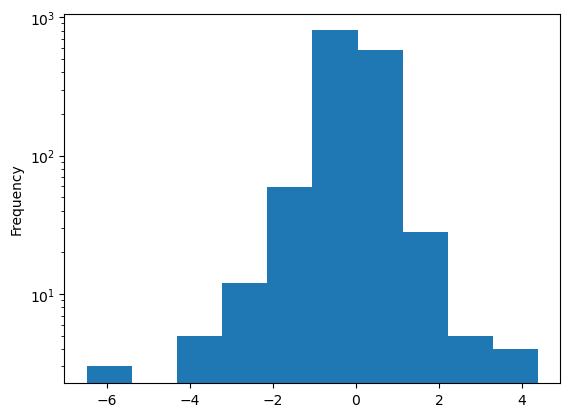

In [143]:
Return.plot(kind='hist', logy=True)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train, Return, test_size=0.3, random_state=20
)

In [180]:
model = xgb.XGBRegressor(kwargs=grid_search.best_params_)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None,
             kwargs={'learning_rate': 0.01, 'max_depth': 5,
                     'n_estimators': 100},
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

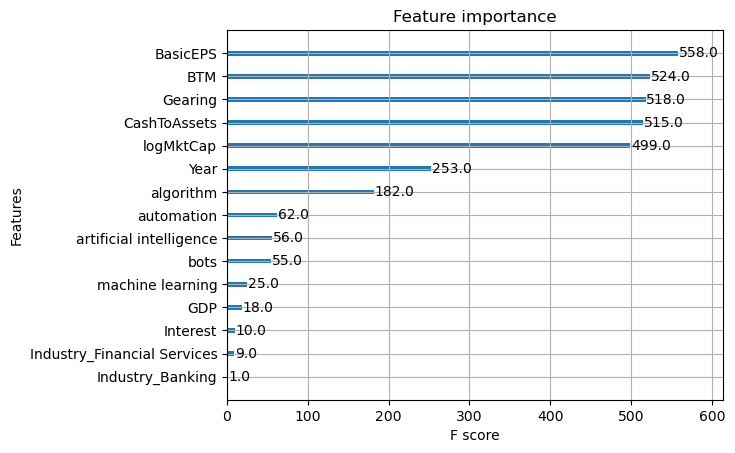

In [181]:
xgb.plot_importance(model)

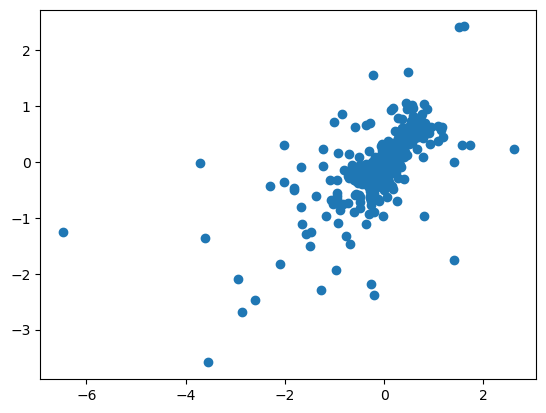

In [147]:
plt.scatter(x=y_test, y=model.predict(X_test))
# plt.xlim(-1,1.5)
# plt.ylim(-1,1.5)
plt.show()

In [ ]:
xgb.plot_importance(model, color=colors_hex[0])
plt.show()

In [133]:
df_train

,Year,algorithm,artificial intelligence,automation,bots,machine learning,BasicEPS,CashAndCashEquivalents,TotalAssets,TotalDebt,TangibleBookValue,TotalCapitalization,Industry_Aviation,Industry_Banking,Industry_Financial Services
0,2020,0.318409,0.000000,0.243711,0.000000,0.000000,1.91,61806000.0,7.980080e+08,86000.0,111062000.0,111148000.0,0,1,0
1,2021,0.312070,0.492463,0.345938,0.138467,0.000000,1.70,65185000.0,9.367140e+08,49000.0,126076000.0,126125000.0,0,1,0
2,2022,0.327686,0.640856,0.407673,0.243714,0.717550,2.40,149156000.0,1.178770e+09,49000.0,143735000.0,126125000.0,0,1,0
3,2023,0.321426,0.577837,0.370036,0.000000,0.598433,2.40,164122000.0,1.395639e+09,49000.0,158158000.0,126125000.0,0,1,0
4,2020,0.318409,0.000000,0.243711,0.000000,0.000000,2.46,208083000.0,5.182879e+09,336538000.0,463064000.0,692069000.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2022,0.000000,0.597137,0.326169,0.000000,0.000000,-0.32,88454988.0,2.284360e+08,9374756.0,213570921.0,222326096.0,0,0,0
1457,2023,0.000000,0.581018,0.284989,0.000000,0.000000,-0.32,101638557.0,2.138408e+08,8876567.0,191702904.0,198207152.0,0,0,0
1458,2022,0.000000,0.597137,0.326169,0.000000,0.000000,-0.01,155795.0,1.521694e+07,8113476.0,3158298.0,10603862.0,0,0,0
1459,2023,0.000000,0.581018,0.284989,0.000000,0.000000,-0.16,1734040.0,3.789861e+07,3646392.0,-50015142.0,15766093.0,0,0,0


In [140]:
print(df_train.iloc[:1100,:], Return.iloc[:1100])

      Year  algorithm  artificial intelligence  automation      bots  \
0     2020   0.318409                 0.000000    0.243711  0.000000   
1     2021   0.312070                 0.492463    0.345938  0.138467   
2     2022   0.327686                 0.640856    0.407673  0.243714   
3     2023   0.321426                 0.577837    0.370036  0.000000   
4     2020   0.318409                 0.000000    0.243711  0.000000   
...    ...        ...                      ...         ...       ...   
1095  2022   0.263436                 0.401637    0.365664  0.796456   
1096  2023   0.252538                 0.384241    0.375821  0.000000   
1097  2022   0.263436                 0.401637    0.365664  0.796456   
1098  2023   0.252538                 0.384241    0.375821  0.000000   
1099  2020   0.229076                 0.309275    0.474241  0.667073   

      machine learning   BasicEPS  CashAndCashEquivalents   TotalAssets  \
0             0.000000   1.910000              61806000.0  7

In [141]:
mod = xgb.XGBRegressor(learning_rate =0.05, max_depth=10, n_estimators = 50)
mod.fit(df_train.iloc[:1100,:], Return.iloc[:1100])
mod.predict(df_train.iloc[1100:])

array([ 2.65403581e+00,  2.65403581e+00, -7.77278900e-01,  6.32500648e+00,
       -7.77278900e-01, -2.92516083e-01,  9.76824760e-01, -1.53852701e-01,
       -2.41347849e-01,  6.57600045e-01, -8.11918229e-02, -4.33898240e-01,
       -5.66245198e-01, -4.80534613e-01,  9.76824760e-01, -2.23819003e-01,
       -3.18842232e-01, -7.77278900e-01,  2.65403581e+00, -7.37660766e-01,
       -6.40881836e-01, -7.77278900e-01,  9.94450474e+00,  2.20548248e+00,
        2.20548248e+00, -2.72097409e-01, -4.78543878e-01, -5.05134284e-01,
        8.85825753e-02,  8.79248142e+00, -4.68429267e-01, -1.44878462e-01,
       -7.77278900e-01,  6.69008684e+00,  5.05659640e-01, -7.20946193e-01,
        1.45289466e-01, -3.66278678e-01, -4.40122038e-01,  6.30418181e-01,
       -4.89300668e-01, -3.40666056e-01, -2.65723735e-01, -2.65723735e-01,
       -7.77278900e-01,  2.20953503e+01,  1.17993450e+00,  1.16661572e+00,
        7.49039948e-01,  5.84887838e+00,  2.20548248e+00,  8.85825753e-02,
       -3.44950736e-01,  